# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [4]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [5]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
#env_info = env.reset(train_mode=False)[brain_name] # reset the environment
#state = env_info.vector_observations[0]            # get the current state
#score = 0                                          # initialize the score
#while True:
#    action = np.random.randint(action_size)        # select an action
#    env_info = env.step(action)[brain_name]        # send the action to the environment
#    next_state = env_info.vector_observations[0]   # get the next state
#    reward = env_info.rewards[0]                   # get the reward
#    done = env_info.local_done[0]                  # see if episode has finished
#    score += reward                                # update the score
#    state = next_state                             # roll over the state to next time step
#    if done:                                       # exit loop if episode finished
#        break
#    
#print("Score: {}".format(score))

When finished, you can close the environment.

In [9]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [15]:
import torch
from torchsummary import summary
from collections import deque
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
"""DNN Model to hold Q-values for DQN algorithm
"""
class QNetwork(torch.nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(state_size, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 4)
        
    def forward(self, x):
        x = self.fc1(x).clamp(min=0)
        x = self.fc2(x).clamp(min=0)
        x = self.fc3(x)
        return x
    
model = QNetwork()
summary(model, (37,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,432
            Linear-2                   [-1, 64]           4,160
            Linear-3                    [-1, 4]             260
Total params: 6,852
Trainable params: 6,852
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [9]:
"""
Implements logic for DQN experience store
"""
class ExperienceStore:
    def __init__(self, size):
        self._store = deque(maxlen=size)
        
    def sample(self, batch_size):
        """Returns a sample of size 'batch_size' from experience store
        """
        experiences = random.sample(self._store, batch_size)
        states = [e[0] for e in experiences]
        actions = [e[1] for e in experiences]
        rewards = [e[2] for e in experiences]
        next_states = [e[3] for e in experiences]
        dones = [(1 if e[4] else 0) for e in experiences]
        
        batch = (states, actions, rewards, next_states, dones)
        
        return [torch.from_numpy(np.vstack(b)).float() for b in batch]
    
    def add(self, experience):
        """Adds an experience to the experince store
        Params
        -------
        experience : tuple (state, action, reward, next_state, done)
        """
        self._store.append(experience)
    
    def __len__(self):
        return len(self._store)

In [10]:
EPSILON_DECAY_FACTOR = 0.995
GAMMA = 0.99
BATCH_SIZE = 128
LEARNING_RATE = 0.0005
EXPERIENCE_STORE_SIZE = 1000000
LEARN_EVERY_STEPS = 4
TAU = 0.001

"""
DQN Agent and DQN training logic.
"""
class Agent:
    def __init__(self, use_soft_update=True, trains_per_cycle=1, use_double_dqn=True):
        """Agent constructor
        Params
        -------
        use_soft_update : True if soft update of the target network should be used. 
        trains_per_cycle : count of optimizer steps to perform if train() is triggered
        use_double_dqn : True if DDQN algorithm for training should be usd
        """
        self.qnetwork_target = QNetwork()
        self.qnetwork_local = QNetwork()
        self.optimizer = torch.optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)
        self.experience_store = ExperienceStore(EXPERIENCE_STORE_SIZE)
        self.step_count = 0
        self.use_soft_udate = use_soft_update
        self.use_double_dqn = use_double_dqn
        self.trains_per_cycle = trains_per_cycle
        
    def calc_action(self, state, epsilon):
        """Calculates next action by e-greedy
        Params
        -------
        state : environment state
        epsilon : epsilon for epsilon gredy
        
        returns action
        """
        state = torch.from_numpy(np.expand_dims(state, axis=0)).float()
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        return np.argmax(action_values.data.numpy()) if random.random() > epsilon else np.random.randint(action_size)
    
    def save_experience(self, experience):
        """Saves experiences in experience store
        Params
        -------
        experience : tuple (state, action, reward, next_state, done)
        """
        self.experience_store.add(experience)
    
    def train(self):
        """Trigger to start a single training cycle
        """
        self.step_count += 1
        self.qnetwork_local.train()
        if len(self.experience_store) > BATCH_SIZE and self.step_count % LEARN_EVERY_STEPS == 0:
            
            for i in range(self.trains_per_cycle):
                states, actions, rewards, next_states, dones = self.experience_store.sample(BATCH_SIZE)
                with torch.no_grad():
                    if self.use_double_dqn:
                        argmax_actions = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1).long()
                        target = rewards + GAMMA * self.qnetwork_target(next_states).gather(1, argmax_actions)
                    else:
                        target = rewards + GAMMA * self.qnetwork_target(next_states).max(1)[0].unsqueeze(1) * (1 - dones)

                action_values = self.qnetwork_local(states).gather(1, actions.long())
                loss = torch.nn.functional.mse_loss(action_values, target)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
        if self.use_soft_udate:
            self.soft_update(self.qnetwork_local, self.qnetwork_target)  
        else: 
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())            

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
    
def decay_epsilon(epsilon):
    return epsilon * EPSILON_DECAY_FACTOR

In [11]:
def dqn(agent, n_episodes=1000, epsilon_max=1.0, epsilon_min=0.005):
    scores = []
    start_time = time.time()
    epsilon=epsilon_max
    for episode in range(1, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.calc_action(state, epsilon)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0] 
            score += reward
            done = env_info.local_done[0]
            agent.save_experience((state, action, reward, next_state, done))
            agent.train()
            state = next_state 

            if done:
                break

        epsilon = max(decay_epsilon(epsilon), epsilon_min)
        scores.append(score)
        score = 0
        print("\rEpisode {}, Rolling average {:.2f}, epsilon {:.3f}, runtime {:.1f}"
              .format(episode, np.mean(scores[-100:]), epsilon, (time.time() - start_time)), end="")
        if episode % 100 == 0:
            print("\rEpisode {}, Rolling average {:.2f}, epsilon {:.3f}, runtime {:.0f}"
                  .format(episode, np.mean(scores[-100:]), epsilon, (time.time() - start_time)))
    return scores

In [12]:
agents = \
{
    'dqn': Agent(use_soft_update=False, trains_per_cycle=3, use_double_dqn=False),
    'ddqn (no soft-update)': Agent(use_soft_update=False, trains_per_cycle=3, use_double_dqn=True),
    'ddqn (soft-update)': Agent(use_soft_update=True, trains_per_cycle=1, use_double_dqn=True)
}

agent_scores = {}
for agent_name, agent in agents.items():
    print('\nAgent: ' + agent_name)
    agent_scores[agent_name] = dqn(agent, n_episodes=1000)


Agent: dqn
Episode 100, Rolling average 0.13, epsilon 0.606, runtime 143.2
Episode 200, Rolling average 0.46, epsilon 0.367, runtime 290.2
Episode 300, Rolling average 1.29, epsilon 0.222, runtime 439.4
Episode 400, Rolling average 1.31, epsilon 0.135, runtime 591.8
Episode 500, Rolling average 1.43, epsilon 0.082, runtime 750.3
Episode 600, Rolling average 2.26, epsilon 0.049, runtime 918.5
Episode 700, Rolling average 2.44, epsilon 0.030, runtime 1097.4
Episode 800, Rolling average 3.01, epsilon 0.018, runtime 1339.9
Episode 900, Rolling average 4.17, epsilon 0.011, runtime 1557.6
Episode 999, Rolling average 4.83, epsilon 0.007, runtime 1808.7
Agent: ddqn (no soft-update)
Episode 100, Rolling average 0.39, epsilon 0.606, runtime 164.5
Episode 200, Rolling average 3.52, epsilon 0.367, runtime 336.8
Episode 300, Rolling average 6.04, epsilon 0.222, runtime 506.6
Episode 400, Rolling average 7.46, epsilon 0.135, runtime 693.2
Episode 500, Rolling average 8.03, epsilon 0.082, runtime 8

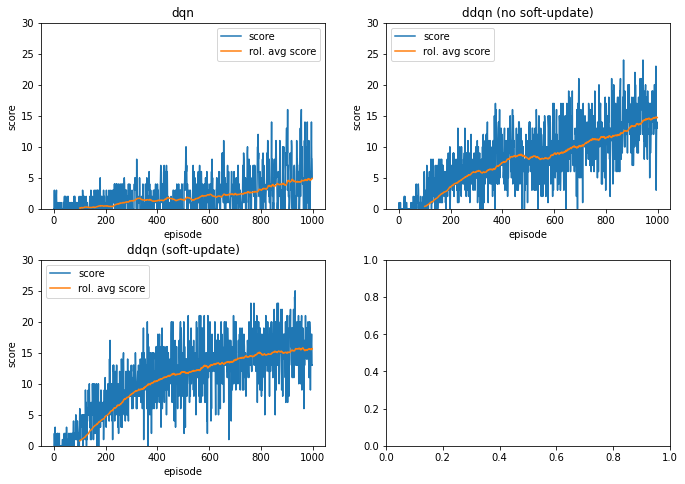

In [13]:
fig, axs = plt.subplots(int(np.ceil(len(agent_scores)/2)), 2, figsize=(10, 7))
fig.tight_layout(pad=3.0)

count = 0
for agent_name, scores in agent_scores.items():
    rolling_averages = [np.mean(scores[i - 100: i]) for i in range(100, len(scores))]
    ax = axs[int(count / 2), count % 2]
    ax.plot(range(len(scores)), scores, label="score")
    ax.plot(range(100, len(scores)), rolling_averages, label="rol. avg score")
    ax.set_ylim(0, 30)
    ax.set_xlabel("episode")
    ax.set_ylabel("score")
    ax.set_title(agent_name)
    ax.legend()
    count += 1
    
plt.show()

### Save agent

In [15]:
def save_agent(agent, path):
    torch.save({
        "qnetwork_local": agent.qnetwork_local.state_dict(),
        "epsilon": 0.005
    }, path)
    
def load_agent(path):
    agent = Agent()
    checkpoint = torch.load(path)
    agent.qnetwork_local.load_state_dict(checkpoint["qnetwork_local"])
    epsilon = checkpoint["epsilon"]
    return agent, epsilon

best_agent = agents['ddqn (soft-update)']
save_agent(agent, "model.pt")
checkpoint_agent, epsilon = load_agent("model.pt")


### Agent example run

In [17]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = checkpoint_agent.calc_action(state, epsilon)       # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 21.0
